# Sample Analysis lab book

Sample analysis lab book to demonstrate standard analysis procedures for electron spectrometers 
We will assume simplified conditions (no warping of screens and linear spatial scales)

## Import Libraries

In [42]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from scipy import signal, ndimage

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

import cv2
import matplotlib.pyplot as plt

def gaus(x,a,x0,sigma,bkg):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + bkg

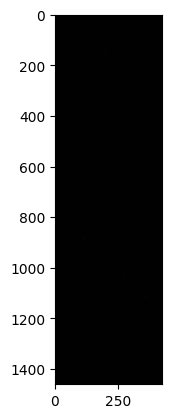

In [43]:


# Load the image
img = cv2.imread('/Users/lukecalvin/2023/ELI-NP DATA/espec/20231128/run_03_(5_shots_after_2cm_shots)/Espec_#0027_000001.tif') 

# Create a copy of the image
img_copy = np.copy(img)

# # Convert to RGB so as to display via matplotlib
# # Using Matplotlib we can easily find the coordinates
# # of the 4 points that is essential for finding the 
# # transformation matrix
# img_copy = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)

plt.imshow(img_copy)




#All points are in format [cols, rows]
pt_A = [653, 483]
pt_B = [1470, 1614]
pt_C = [1754, 1311]
pt_D = [892, 131]



# Here, I have used L2 norm. You can use L1 also.
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))
 

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])


# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)
out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
#img = out
plt.imshow(out)
img = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)








## Read in file

In [44]:
# image = Image.fromarray(img_final)
# image.save("output_image.tiff")


# filename_test= '/Users/temourfoster/Desktop/spectra_analysis/shot3.Tiff'
# img_test = plt.imread(filename_test)

# filename = '/Users/temourfoster/Desktop/spectra_analysis/output_image.tiff'
# img = plt.imread(filename)

# #fit_param_file = '/Users/jyotirupsarma/pdoc/Experiments/ELI-BL/data/2023-10-4/analysis/Spectra_analysis/Burst2/Summary_file.txt'

## Constants

In [45]:
lanex_size_x_mm = 290
# size of lanex in horizontal (dispersion) axis. 

Assumption is that camera and screen are normal and screen matches the field of view of the camera

## Plot raw image

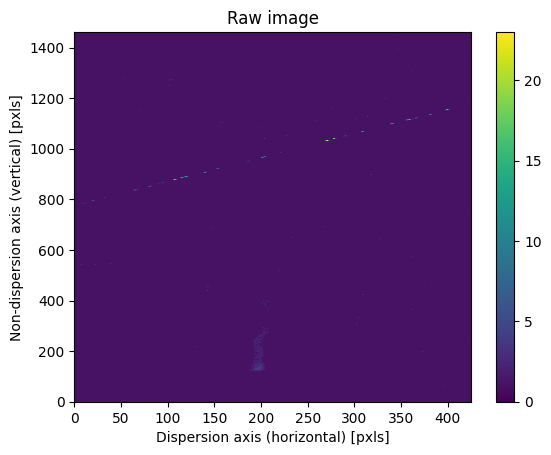

In [46]:
fig, ax = plt.subplots()

pc = ax.pcolor(img)
ax.set_title('Raw image')
ax.set_xlabel('Dispersion axis (horizontal) [pxls]')
ax.set_ylabel('Non-dispersion axis (vertical) [pxls]')
plt.colorbar(pc)
plt.show()

## Background subtraction

Applying a simple median filter. If there is a lot of background one could also look at background outside of ROI and fit a smooth surface to identify gradients on the image or the chip.

In [47]:
#img_filt = signal.medfilt2d(img, kernel_size=3)
img_filt = ndimage.median_filter(img,4 )

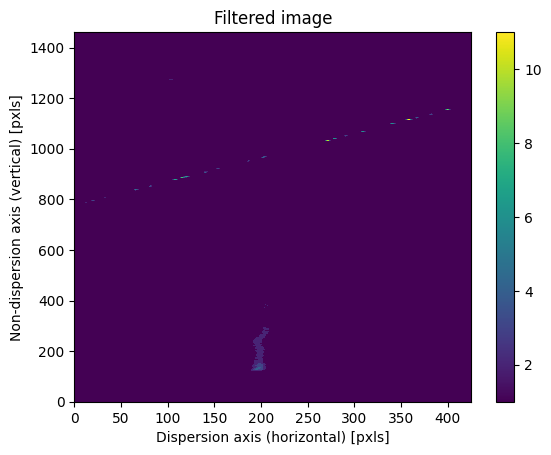

In [48]:
fig, ax = plt.subplots()

pc = ax.pcolor(img_filt)# vmax=0.5e4)
ax.set_title('Filtered image')
ax.set_xlabel('Dispersion axis (horizontal) [pxls]')
ax.set_ylabel('Non-dispersion axis (vertical) [pxls]')
plt.colorbar(pc)
plt.show()

Looking at the counts projection onto the y axis to see how the background is and then to select a region for background subtraction

In [ ]:
ProjY = np.sum(img_filt,1) #pixel counts projection onto the y-axis (non-dispersion axis)
y_axis_pxl = np.array(range(len(ProjY))) # y axis array in pixel
plt.plot(y_axis_pxl,ProjY)
plt.xlabel('Non-dispersion axis (vertical) [pxls]')
plt.ylabel('Counts summed all over along x')


In [ ]:
extra_ProjY = ProjY[y_axis_pxl>200] # By eye we know that the main signal in this case is towards the right of 200.So just selecting this region.
extra_y_axis_pxl = y_axis_pxl[y_axis_pxl>200]
mean = extra_y_axis_pxl[np.argmax(extra_ProjY)] # The position of the peak (after we truncate the axis(>200) to avoid the peaks at the left). This will be used as input paramter to fit the gaussian.

plt.plot(extra_y_axis_pxl, extra_ProjY)

popt,pcov = curve_fit(gaus,extra_y_axis_pxl,extra_ProjY,p0=[0.9e7,mean,10,100], maxfev=5000)

plt.plot(extra_y_axis_pxl, gaus(extra_y_axis_pxl, *popt))
popt

In [ ]:

Amp, Max_pos,sigma,bkg = popt
waist = sigma*2
FWHM = waist*np.sqrt(2*np.log(2))
# print(Max_pos,FWHM, waist, sigma)

    

# selcecting background region based on the fit profile

In [ ]:
waist_factor = 2 # a factor to multiply waist when selecting the background region
bkg_y_bottom_select = [int(Max_pos-waist_factor*waist-100), int(Max_pos-waist_factor*waist)]
bkg_bottom = img_filt[bkg_y_bottom_select[0]:bkg_y_bottom_select[1],:] 

bkg_y_top_select = [int(Max_pos+waist_factor*waist), int(Max_pos+waist_factor*waist+100)]
bkg_top = img_filt[bkg_y_top_select[0]:bkg_y_top_select[1],:]
# print(np.shape(bkg_top))
# print(np.shape(bkg_bottom))
# print(bkg_y_bottom_select[0],bkg_y_bottom_select[1])
bkg = (bkg_bottom + bkg_top)/2
bkg = np.mean(bkg,axis=0)

print(np.shape(bkg_top))
print(np.shape(bkg_bottom))


In [ ]:
ROI_y = [int(Max_pos-waist_factor*waist),int(Max_pos+waist_factor*waist)] 

img_ROI = img_filt[ROI_y[0]:ROI_y[1],:] #selecting the region of interest. beyind this the bkg was selected

img_ROI = img_ROI-bkg # subtracting background
img_ROI[img_ROI<0] = 0

fig, ax = plt.subplots()

pc = ax.pcolor(img_ROI)
ax.set_title('ROI bkg subtracted')
ax.set_xlabel('Dispersion axis (horizontal) [pxls]')
ax.set_ylabel('Non-dispersion axis (vertical) [pxls]')
plt.colorbar(pc)
plt.show()
# From here on img_ROI is the image to analyse which background subtracted

In [ ]:


# plt.plot(np.sum(img_ROI, axis=0), label='Bkg sub')
# plt.legend()
# plt.show()
# plt.xlabel('dispersion axis in pxl')
# plt.ylabel('Counts per pxl')

# plt.plot(np.mean(bkg_bottom, axis=0),label='bottom mean Bkg')
# plt.plot(np.mean(bkg_top, axis=0),label='top mean Bkg')
# plt.show()

# plt.pcolormesh(img_filt-bkg,vmax=5e3)
# plt.colorbar()
# plt.title('Full image (bkg subtracted)')
# plt.axhline(bkg_y_bottom_select[0], color='r')
# plt.axhline(bkg_y_bottom_select[1], color='r')
# plt.axhline(bkg_y_top_select[0], color='g')
# plt.axhline(bkg_y_top_select[1], color='g')
# plt.show()

elower = np.linspace(0,1900,num=30, endpoint=True)
bin_start = elower[1]
bin_end = bin_start +  elower[-1]
eupper = np.linspace(bin_start,bin_end,num=30, endpoint=True)

##### This part to calculate sigma over energy #####################
ediv_list = []
energy_axis_for_div = []

# for i, j in zip(elower, eupper):
#     i, j = int(i), int(j)
#     ProjY = np.sum(img_ROI[:, i:j],1) # projection onto the y-axis (non-dispersion axis)
#     y_axis_pxl = np.array(range(len(ProjY)))
    
#     energy_bin_mean = (x_axis_MeV[i] + x_axis_MeV[j])/2
#     bin_size = x_axis_MeV[j] - x_axis_MeV[i]
#     energy_axis_for_div.append(energy_bin_mean)
    
#     ediv_list.append(gausfitparam(y_axis_pxl/pxls_per_mm,ProjY)[3])
    
# plt.plot(energy_axis_for_div, ediv_list)
# ediv_list = np.array(ediv_list)
# plt.plot(energy_axis_for_div, np.arctan(ediv_list*1e-3/2.8)*1e3) # 2.8 is distance in meters from gas to lanex screen
# plt.xlabel('E [MeV]')
# plt.ylabel('$\sigma$ [mrad]')



Now to get the spectrum we need to look at the counts projection on the x axis (the dispersion axis). Also, the projection on the y axis (non dispersion axis) will give the divergence of the beam.

In [ ]:
ProjX = np.sum(img_ROI,0) # projection onto the x-axis (dispersion axis)
ProjY = np.sum(img_ROI,1) # projection onto the y-axis (non-dispersion axis)
x_axis_pxl = np.array(range(len(ProjX)))
y_axis_pxl = np.array(range(len(ProjY)))

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(x_axis_pxl, ProjX)
ax[1].plot(y_axis_pxl, ProjY)

ax[0].set_xlim(min(x_axis_pxl),max(x_axis_pxl))
ax[1].set_xlim(min(y_axis_pxl),max(y_axis_pxl))

ax[0].set_xlabel('Dispersion axis (horizontal) [pxls]')
ax[1].set_xlabel('Non-dispersion axis (vertical) [pxls]')

ax[0].set_ylabel('Counts per pixel [counts/pxls]')
ax[1].set_ylabel('Counts per pixel [counts/pxls]')

plt.show()

pixel to mm axis conversion

In [ ]:
pxls_per_mm = len(x_axis_pxl)/lanex_size_x_mm
print('Pixels per mm: ' + str(pxls_per_mm) + ', or mm per pixel (equivalent size of pixel): ' + str(1/pxls_per_mm))

x_axis_mm = x_axis_pxl/pxls_per_mm # change scaling of axis from pxls to mm
y_axis_mm = y_axis_pxl/pxls_per_mm # this is a linear change and simply a constant

dNdx = ProjX*pxls_per_mm # coordinate transformation from dN/dpxl to dN/dx requires dN/dpxl * dpxl/dx. dpxl/dx = pxls_per_mm 
dNdy = ProjY*pxls_per_mm

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(x_axis_mm, dNdx)
ax[1].plot(y_axis_mm, dNdy)

ax[0].set_xlim(min(x_axis_mm),max(x_axis_mm))
ax[1].set_xlim(min(y_axis_mm),max(y_axis_mm))

ax[0].set_xlabel('Dispersion axis (horizontal) [mm]')
ax[1].set_xlabel('Non-dispersion axis (vertical) [mm]')

ax[0].set_ylabel('Counts per mm [counts/mm]')
ax[1].set_ylabel('Counts per mm [counts/mm]')

plt.show()

## Dispersion curve

Parametrisation that can be obtained from a particle tracing code or flulka. There is obviously an issue when using x = 0 due to the logarithm

In [ ]:
def disp(x_mm):
    E_MeV = 1130 - np.log(x_mm/10)*225
    return E_MeV

x_axis_mm[0:5]

In [ ]:
plt.plot(x_axis_mm, disp(x_axis_mm))
plt.title('Dispersion curve')
plt.xlabel('Position on screen [mm]')
plt.ylabel('Electron Energy [MeV]')
plt.show()

Note that the axis is inverted relative to the previous plot. Right was high energy for the spectrum but here left is high energy.

In [ ]:
plt.plot(np.flip(x_axis_mm), disp(x_axis_mm))
plt.xlabel('Position on screen [mm]')
plt.ylabel('Electron Energy [MeV]')
plt.title('Correct coordinates for screen')
plt.show()

In [ ]:
gradient =  (x_axis_mm[1:-1]+x_axis_mm[2:])/2 - (x_axis_mm[0:-2]+x_axis_mm[1:-1])/2

In [ ]:
left_bin_edges_mm = (x_axis_mm[0:-2]+x_axis_mm[1:-1])/2
right_bin_edges_mm = (x_axis_mm[1:-1]+x_axis_mm[2:])/2
bin_centres_mm = x_axis_mm[1:-1]
left_bin_edges_MeV = disp(left_bin_edges_mm)
right_bin_edges_MeV = disp(right_bin_edges_mm)
bin_centres_MeV = disp(bin_centres_mm)
mm_per_MeV = -(right_bin_edges_mm - left_bin_edges_mm)/(right_bin_edges_MeV - left_bin_edges_MeV) # minus sign because axis is flipped
# could instead directly calculate gradient of the dispersion function



In [ ]:
x_axis_MeV = np.flip(bin_centres_MeV)
dNdE = dNdx[1:-1]*np.flip(mm_per_MeV) # dN/dE = dN/dX * dX/dE. This takes care of the fact that towards the lower energy, electrons are more spread out on the screen than the higher energy.

In [ ]:
plt.plot(np.flip(x_axis_MeV), mm_per_MeV)
plt.xlabel('Electron Energy [MeV]')
plt.ylabel('mm per MeV [MeV]')
plt.title('Gradient')
plt.show()

In [ ]:
plt.plot(x_axis_MeV, dNdE)
plt.xlabel('Electron energy(MeV)')
plt.ylabel('Counts per MeV [counts/MeV]')
plt.xlim(min(x_axis_MeV),800)

Peak_energy, Energy_FWHM, energy_waist, energy_sigma = gausfitparam(x_axis_MeV,dNdE)
print(Peak_energy, Energy_FWHM, energy_waist, energy_sigma)

        


Cropping along energy axis of the actual image to see the divergence of the peak

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(x_axis_MeV, dNdE, label = 'proper transformation')
ax[0].plot(x_axis_MeV, dNdx[1:-1], label = 'no transformation')

ax[0].set_xlim(min(x_axis_MeV),max(x_axis_MeV))

ax[0].set_title('Comparison full range')
ax[0].set_xlabel('Electron energy [MeV]')
ax[0].set_ylabel('Counts per MeV [counts/MeV]')
ax[0].legend()

ax[1].plot(x_axis_MeV, dNdE/max(dNdE), label = 'proper transformation')
ax[1].plot(x_axis_MeV, dNdx[1:-1]/max(dNdx[1:-1]), label = 'no transformation')

ax[1].set_xlim(min(x_axis_MeV),750)

ax[1].set_title('Normalised to maximum, zoomed in')
ax[1].set_xlabel('Electron energy [MeV]')
ax[1].set_ylabel('Counts per MeV, normalised [counts/MeV]')
ax[1].legend()

plt.show()